##**BITS F464 - Semester 1 - MACHINE LEARNING**
--------------------------------------------------------------------------------

**ASSIGNMENT 2 – DECISION TREES AND SUPPORT VECTOR MACHINES**
--------------------------------------------------------------------------------
*-Please rename the file as "TeamXX_Assignment2.ipynb"*

***Team number:23***

---
(*In Title case, separated with commas*)
***Full names of all students in the team:Avaneesh Kulkarni , Nilay Girgaonkar ,Harshavardhan Gali , Kritikka Paul , Shrey Singhal***

---
(*Separated by commas*)
***2021A4PS2560H, 2021AAPS0566H , 2021AAPS0691H , 2021AAPS0628H , 2021A4PS3097H:***


This assignment aims to identify the differences between three Machine Learning models.

# ***1. Preprocess and perform exploratory data analysis of the dataset obtained***

#**Importing the Data**

In [ ]:
from google.colab import drive
# Importing required header files for the project
import pandas as pd
import io
import numpy as np
from google.colab import files
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import requests
# Mount Google Drive
drive.mount('/content/drive')

# Read the .data file from Google Drive
data_path = '/content/drive/My Drive/communities.data'
df = pd.read_csv(data_path)

# Read the .names file - Example to extract column names
names_path = '/content/drive/My Drive/communities.names'
with open(names_path, 'r') as file:
    lines = file.readlines()

column_names = []
for line in lines:
    if line.startswith('@attribute'):
        column_info = line.split()
        column_names.append(column_info[1])  # Extracting column names


df.columns = column_names


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Clearing Columns with excessive NaN values**

In [ ]:
#Replacing the ? with NaN
df.replace("?", np.nan, inplace = True)

#dropping non predictive attributes
df = df.drop(columns=['state','county',
                          'community','communityname',
                          'fold'], axis=1)

#dropping columns with too many nan values
feat_missing = df.columns[df.isnull().any()]
feat_missing = feat_missing.drop("OtherPerCap") #as it has only one missing value
df = df.drop(columns=feat_missing, axis = 1)

avg = df['OtherPerCap'].astype('float').mean()
df['OtherPerCap'].replace(np.nan, avg, inplace=True) #replacing with mean
df = df.astype({"OtherPerCap": float})
#df.info()

#**Binning of Target Variable Data**

In [ ]:
number_bins = 4

#creating bins
bins = np.linspace(0,1,number_bins+1)
group_names = []
diff = 1/(number_bins)
curr = 0
bin_names = []
for i in range(number_bins):
  bin_names.append(i+1)

df['ViolentCrimesPerPop']=pd.cut(df['ViolentCrimesPerPop'], bins, labels = bin_names, include_lowest = True)
df = df.astype({"ViolentCrimesPerPop": int})

# **Splitting into Test and Train Data**

In [ ]:
#splitting into training and test data
ratio = 0.7

shuffle_df = df.sample(frac=1, ignore_index = True)
train_size = int(ratio * len(df))
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

X_train = train_set.drop('ViolentCrimesPerPop', axis=1)
X_test = test_set.drop('ViolentCrimesPerPop', axis=1)
Y_train = train_set['ViolentCrimesPerPop']
Y_test = test_set['ViolentCrimesPerPop']
#X_test.head()
#Y_test.head()

#**Applying Coeffecient Correlation to keep only relevant features**

##**Correlation Matrix Before Dimensionality Reduction**

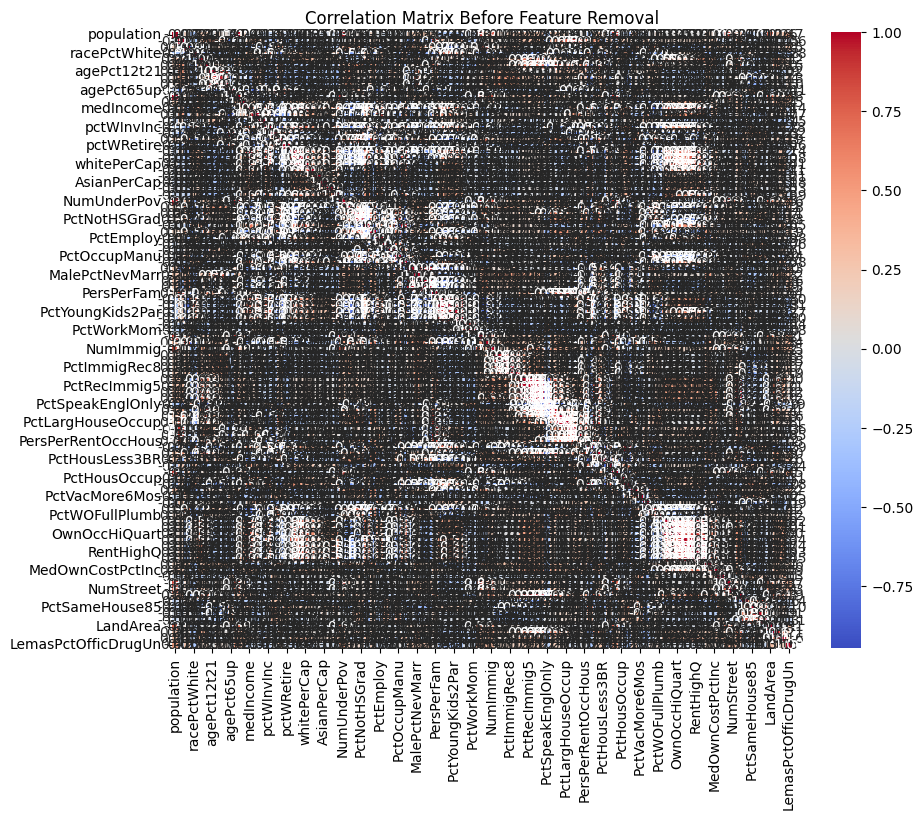

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix before feature removal
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before Feature Removal')
plt.show()

In [ ]:
#finding highly correlated attributes

def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix =  dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i, j] > threshold:
        colname=corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

threshold = 0.4
corr_features = correlation(X_train, threshold)
X_train.drop(corr_features, axis = 1, inplace=True)
X_test.drop(corr_features, axis = 1, inplace=True)
train_set.drop(corr_features, axis = 1, inplace = True)

X_train.shape

<ipython-input-193-52f501718ed3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(corr_features, axis = 1, inplace = True)


(1395, 16)

In [ ]:
X_copy = X_train

In [ ]:

# Convert NumPy array to pandas DataFrame with column names
X_copy = pd.DataFrame(X_copy)

# Extract column names and store them in a list
column_names1 = list(X_train.columns)


##**Correlation Matrix After Dimensionality Reduction**

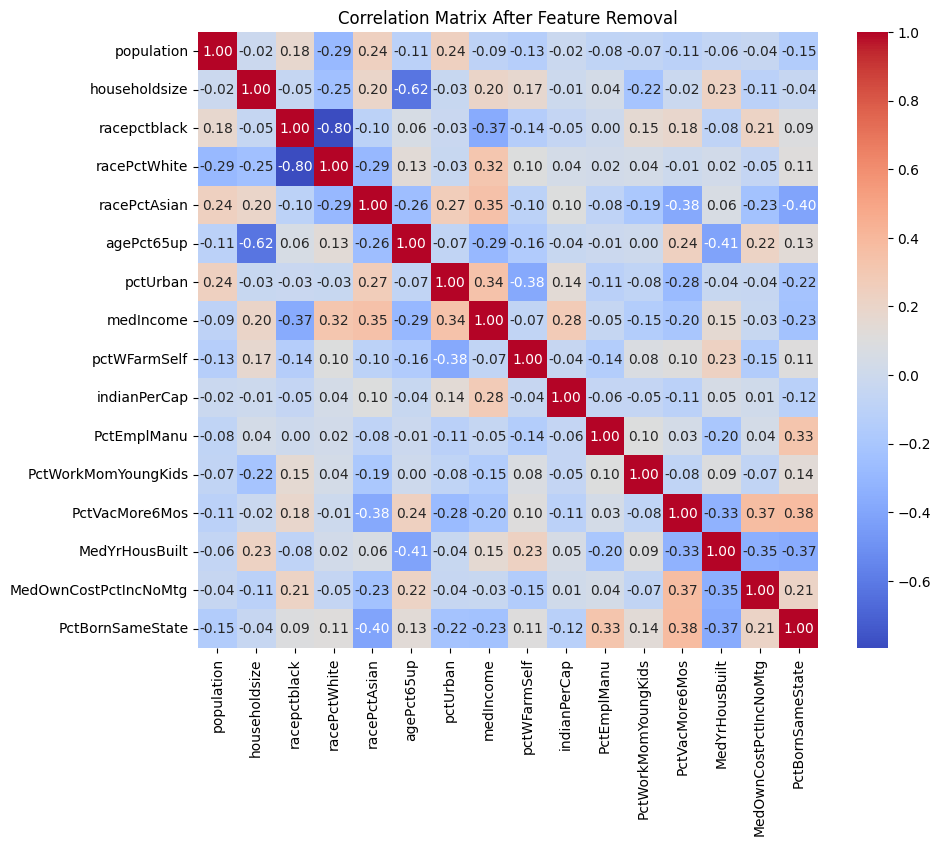

In [ ]:


# Check if columns in corr_features exist in X_train before dropping
corr_features_existing = [col for col in corr_features if col in X_train.columns]

# Plotting the correlation matrix after feature removal
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.drop(corr_features_existing, axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Feature Removal')
plt.show()



# ***2. Decision tree model with entropy implementation***

## **_2.1 Implementation of the Model_**


Decision trees in machine learning are hierarchical models that partition data based on features to make decisions. Each internal node represents a feature test, and branches represent outcomes. The tree is trained using a recursive process to maximize information gain or minimize impurity. Decision trees excel in capturing complex relationships and are interpretable. However, they are prone to overfitting. Techniques like pruning and ensemble methods, such as Random Forests, mitigate this issue, making decision trees valuable for classification and regression tasks in various domains, including finance, healthcare, and natural language processing.

In [ ]:
import collections
from collections import Counter

In [ ]:
class Node:

  def __init__(self, feature=None, threshold=None, left=None, right=None,*, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def isLeafNode(self):
    return self.value is not None

In [ ]:
class DecisionTree:

  def __init__(self, min_samples = 2, max_depth=2):
    self.min_samples = min_samples
    self.max_depth = max_depth
    self.featureCount = None
    self.root = None



  def fit(self, X, Y):
    self.featureCount = X.shape[1] if not self.featureCount else min(X.shape[1], self.featureCount)
    self.root = self.growTree(X, Y)



  def growTree(self, X, Y, depth = 0):
    samples, features = X.shape
    labels = len(np.unique(Y))

    #terminating condition
    if (depth>=self.max_depth or labels == 1 or samples<self.min_samples):
      leaf_value = self.maxFreqLabel(Y)
      return Node(value = leaf_value)

    bestFeature, bestThreshold = self.bestSplit(X, Y)

    leftIndices, rightIndices = self.split(X[:, bestFeature], bestThreshold)

    leftTree = self.growTree(X[leftIndices, :], Y[leftIndices], depth+1)
    rightTree = self.growTree(X[rightIndices, :], Y[rightIndices], depth+1)
    return Node(bestFeature, bestThreshold, leftTree, rightTree)




  def maxFreqLabel(self, Y):
    if len(Y) == 0:
        raise ValueError("Input array Y is empty.")

    counter = Counter(Y)
    if not counter:
        raise ValueError("No unique elements in input array Y.")

    value = counter.most_common(1)[0][0]
    return value


  def split(self, X_vals, splitThreshold):
    left_idxs = np.argwhere(X_vals <= splitThreshold).flatten()
    right_idxs = np.argwhere(X_vals > splitThreshold).flatten()
    return left_idxs, right_idxs




  def bestSplit(self, X, Y):
    bestGain = -1
    splitIndex, splitThreshold = None, None

    for i in range(X.shape[1]):
      X_vals = X[:, i]
      thresholds = np.unique(X_vals)

      for thresh in thresholds:
        gain = self.infoGain(Y, X_vals, thresh)

        if gain>bestGain:
          bestGain = gain
          splitIndex = i
          splitThreshold = thresh

    return splitIndex, splitThreshold



  def infoGain(self, Y, X_vals, threshold):
    parentEntropy = self.entropy(Y)
    leftIndices, rightIndices = self.split(X_vals, threshold)
    numLeft, numRight = len(leftIndices), len(rightIndices)
    total = len(Y)
    if numLeft == 0 or numRight == 0:
      return 0

    entropyLeft, entropyRight = self.entropy(Y[leftIndices]), self.entropy(Y[rightIndices])
    childEntropy = (numLeft/total)*entropyLeft + (numRight/total)*entropyRight

    return parentEntropy - childEntropy



  def entropy(self, Y):
    hist = np.bincount(Y)
    probs = hist/len(Y)
    entro = 0
    for p in probs:
      if p>0:
        entro+=p*np.log(p)

    return entro*-1



  def predict(self, X):
    return np.array([self.traverseTree(res, self.root) for res in X])



  def traverseTree(self, res, node):
    if node.isLeafNode():
      return node.value

    if res[node.feature]<=node.threshold:
      return self.traverseTree(res, node.left)

    return self.traverseTree(res, node.right)




In [ ]:
def accuracy(y_test, y_pred):
  return np.sum(y_test==y_pred)/len(y_test)

In [ ]:
X_train_numpy = X_train.to_numpy()
Y_train_numpy = Y_train.to_numpy()
Y_test_numpy = Y_test.to_numpy()
X_test_numpy = X_test.to_numpy()


model1 = DecisionTree(2, 10)
model1.fit(X_train_numpy, Y_train_numpy)
predictions1 = model1.predict(X_test_numpy)

model2 = DecisionTree(2, 3)
model2.fit(X_train_numpy, Y_train_numpy)
predictions2 = model2.predict(X_test_numpy)

model3 = DecisionTree(2, 17)
model3.fit(X_train_numpy, Y_train_numpy)
predictions3 = model3.predict(X_test_numpy)

acc1 = accuracy(Y_test_numpy, predictions1)
acc2 = accuracy(Y_test_numpy, predictions2)
acc3 = accuracy(Y_test_numpy, predictions3)
print(acc1)

0.6521739130434783


## **_2.2 Insights drawn (plots, markdown explanations)_**

###Conusion Matrix


The confusion matrix provides a detailed view of the performance of a classification algorithm on a dataset. It is particularly useful when dealing with a multi-class classification problem. Each entry (i, j) in the confusion matrix represents the number of instances of class i that were predicted as class j.


Diagonal Elements:
Represent the number of instances correctly classified for each class.
Located from the top-left to bottom-right of the confusion matrix.

Off-Diagonal Elements:
Indicate misclassifications.
Element at (i, j) represents instances of class i predicted as class j.

True Positives (TP):
Found on the diagonal, indicating correct predictions for each class.

False Positives (FP):
Sum of values in each column (excluding diagonal) represents instances incorrectly predicted as each class.

False Negatives (FN):
Sum of values in each row (excluding diagonal) indicates instances of each class incorrectly predicted as other classes.

True Negatives (TN):
Remaining values outside the diagonal represent correctly predicted instances for classes other than the one corresponding to the row.

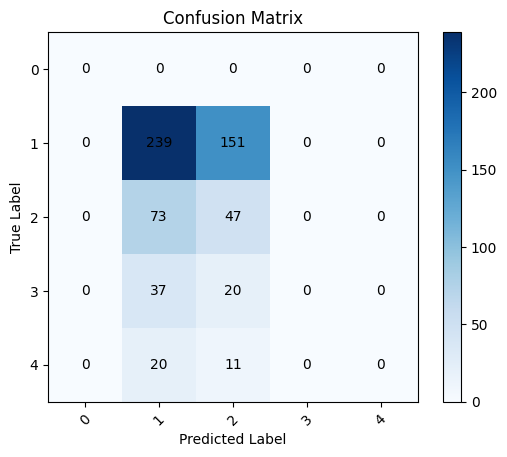

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Convert labels to integers if they are not already
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1

    return cm

def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#num_classes = number_bins
# Assuming y_true and y_pred are your true and predicted labels
num_classes = number_bins+1
cm = confusion_matrix(Y_test_numpy, predictions, num_classes)
class_names = [str(i) for i in range(num_classes)]

plot_confusion_matrix(cm, class_names)

###Accuracy Variation with Tree depth

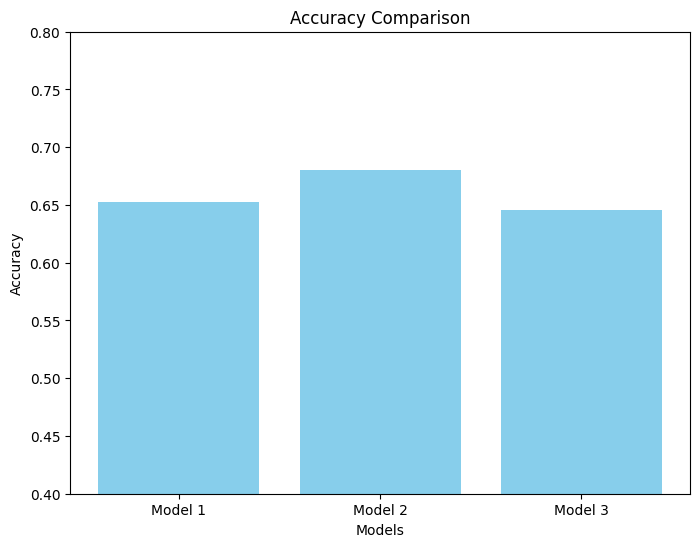

In [ ]:
plt.figure(figsize=(8, 6))
models = ['Model 1', 'Model 2','Model 3']
accuracies = [acc1, acc2,acc3]
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0.4, 0.8)
plt.show()

Here we observe that when the tree depth is too less or too high , the accuracy of the model decreases . The accuracy will reach its peak at an optimal value of max depth

Effect of Tree Depth on Accuracy:
When the tree depth is too low, the model might be too simple to capture the underlying patterns in the data, leading to lower accuracy.
As the tree depth increases, the model becomes more complex and better fits the training data, potentially improving accuracy.
However, if the tree depth becomes too high, the model may start overfitting the training data, capturing noise and outliers, which can result in a decrease in accuracy on new, unseen data (such as a test set).

Optimal Tree Depth:
There exists an optimal value for the tree depth (a "sweet spot") where the model achieves the highest accuracy on the test data.

#***3. Adaboost***

## **_3.1 Implementation of the Model_**


AdaBoost, short for Adaptive Boosting, is an ensemble learning technique in machine learning. It combines weak learners into a strong learner by assigning weights to each instance based on the accuracy of previous learners. It focuses on correcting misclassifications, adjusting weights iteratively. Weak models are sequentially trained, and their outcomes influence subsequent models. AdaBoost is versatile, applicable to various algorithms, and effective in improving accuracy. It is widely used in tasks like face detection, text classification, and biological data analysis, contributing to robust and high-performance models across diverse applications.

In [ ]:
#defining the adaboost algorithm

class Adaboost():

  def __init__(self,df_collection={}, count=3):
    self.df = None
    self.df_collection = df_collection
    self.count=count



  def fit(self, df, X_numpy, Y_numpy, num_classes, count=0):
    self.df = df

    #terminating condition
    if count==self.count:
      return

    #creating decision stumps using decision tree of depth 1
    dt = DecisionTree(2,1)
    dt.fit(X_numpy, Y_numpy)
    df['y_pred'] = dt.predict(X_numpy)

    #calculating error of decision stump
    error = self.calculate_model_error(df)

    #calculating alpha
    alpha = self.calculate_model_weight(error, num_classes)

    #updating weights after aloha calculation
    df['updated_weights'] = df.apply(lambda row: self.update_row_weights(row, alph=alpha), axis=1)
    df['nomalized_weights'] = df['updated_weights']/df['updated_weights'].sum()

    #creating new dataset based on higher weighted rows
    df['cumsum_upper'] = np.cumsum(df['nomalized_weights'])
    df['cumsum_lower'] = df['cumsum_upper'] - df['nomalized_weights']
    indices = self.create_new_dataset(df)
    columnsDrop = ['y_pred', 'error', 'updated_weights', 'cumsum_lower', 'cumsum_upper', 'nomalized_weights']
    new_df = df.iloc[indices]
    new_df = new_df.drop(columnsDrop, axis = 1)

    #running the algorithm on new training samples
    df_collection[alpha] = dt
    X = new_df.drop('ViolentCrimesPerPop', axis = 1).to_numpy()
    Y = new_df["ViolentCrimesPerPop"].to_numpy()
    self.fit(new_df, X,Y, num_classes, count+1)



  def calculate_model_error(self, dataset):
    error = 0
    cols = dataset.shape[1]
    dataset['error'] = (dataset['y_pred'] != dataset['ViolentCrimesPerPop']).astype(int) * dataset['weights']
    return dataset['error'].sum()



  def calculate_model_weight(self, error, K):
    return 0.5*np.log((1-error)/(error+1e-9)) + np.log(K-1) #additional log(k-1) term to improve accuracy according to SAMME algorithm



  def update_row_weights(self, row,alph):
    cols = self.df.shape[1]

    #giving more weightage to misclassified examples
    if row['ViolentCrimesPerPop'] == row['y_pred']:
      return row['weights'] * np.exp(-alph)
    else:
      return row['weights'] * np.exp(alph)



  def create_new_dataset(self, df):
    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and a > row['cumsum_lower']:
                indices.append(index)
    return indices


  def predict_adaboost(self, df_collections, X):
    predictions = np.zeros(X.shape[0])
    sum = 0
    for alpha in df_collections:
      predictions+=alpha*df_collections[alpha].predict(X)
      sum+=alpha
    predictions=predictions/sum
    predictions.round()
    return predictions



In [ ]:
temp_train_set = train_set.copy()
temp_train_set['weights'] = 1/temp_train_set.shape[0]
df_collection={}

#creating and fitting Adaboost model on data
model = Adaboost(df_collection, 1)
model.fit(temp_train_set, X_train_numpy, Y_train_numpy, number_bins)

In [ ]:
predictions = model.predict_adaboost(df_collection, X_test_numpy)
acc = accuracy(Y_test_numpy,predictions)
print(acc)

0.6521739130434783


## **_3.2 Insights drawn (plots, markdown explanations)_**

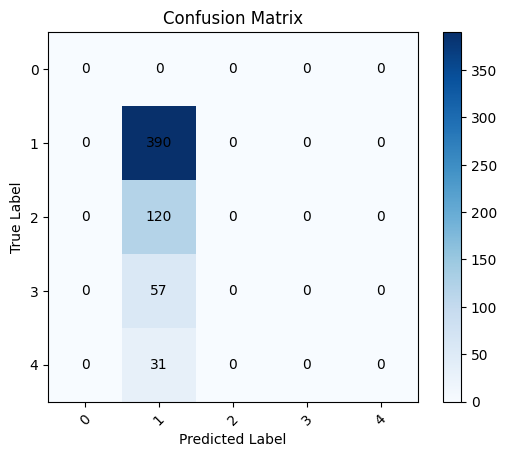

In [ ]:


num_classes = number_bins+1
cm = confusion_matrix(Y_test_numpy, predictions, num_classes)
class_names = [str(i) for i in range(num_classes)]

plot_confusion_matrix(cm, class_names)

#Conusion Matrix and Variation with Iterations
AdaBoost's performance evolves with iterations, initially showing rapid improvement by correcting misclassifications. During middle iterations, the model strikes a balance between capturing complex patterns and avoiding overfitting. There exists an optimal point where accuracy peaks, beyond which additional iterations may lead to diminishing returns or overfitting. Visualizing the accuracy curve helps identify this point. Late iterations risk memorizing training data, causing a decrease in accuracy on new data. AdaBoost's ensemble approach enhances robustness, and regularization techniques like early stopping aid in achieving the best balance between training and generalization.

# **_4. Multiclass SVM_**

## **_4.1 Implementation of the Model_**

In [ ]:


class BinarySVM:
    def __init__(self, learning_rate=0.1, lmb=0.1, n_iters=100):
        self.learning_rate = learning_rate
        self.lmb = lmb
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for _ in range(self.n_iters):
            for i in range(n_samples):
                temp= y[i] * (np.dot(X[i],self.weights)-self.bias)
                temp=temp*np.sign(temp)
                if(temp>=1):
                  temp=0
                else:
                  temp=1
                if temp:
                  self.weights -= self.learning_rate * (2 * self.lmb * self.weights - np.dot(X[i], y[i]))
                  self.bias -= self.learning_rate * y[i] * temp

    def decision_function(self, X):
        temp=np.dot(X,self.weights)-self.bias
        return temp

class MulticlassSVM:
    def __init__(self, learning_rate=0.05, lmb=0.001, n_iters=1000):
        self.lr=learning_rate
        self.lmb = lmb
        self.n_iters = n_iters
        self.classifiers = {}
        self.classes=[]
    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_class = np.where(y == cls, 1, -1)
            classifier = BinarySVM(self.lr, self.lmb, self.n_iters)
            classifier.fit(X, y_class)
            self.classifiers[cls] = classifier

    def predict(self, X):
        m,n=X.shape
        prediction=np.ones((m,1))
        for i in range(m):
          max=-1e20
          clss=0
          temp=[]
          for cls in self.classes:
            curr=self.classifiers[cls].decision_function(X[i])
            temp.append(curr)
            if(curr>max):
              max=curr
              clss=cls
          prediction[i]=clss
        return prediction
def calculate_accuracy(predictions, Y_test_numpy):
    m=len(predictions)
    count=0
    zero=0
    for i in range(m):
        if(predictions[i]==Y_test_numpy[i]):
          count+=1
        if(predictions[i]==0):
          zero+=1
    accuracy=count/m
    return accuracy

# Instantiate and train the Multiclass SVM model
multiclass_svm_model = MulticlassSVM()
multiclass_svm_model.fit(X_train_numpy, Y_train_numpy)

# Make predictions on the test data
#X_t=X_test.to_numpy()
predictions1 = multiclass_svm_model.predict(X_test_numpy)
# Calculate accuracy using the entire testing set
m,n=X_test_numpy.shape
count=0
zero=0
for i in range(m):
    if(predictions[i]==Y_test_numpy[i]):
      count+=1
    if(predictions[i]==0):
      zero+=1
accuracy=count/m
print(zero/m)
print(f"Multiclass SVM classification accuracy: {accuracy * 100:.2f}%")


0.0
Multiclass SVM classification accuracy: 65.22%


## **_4.2 Insights drawn (plots, markdown explanations)_**

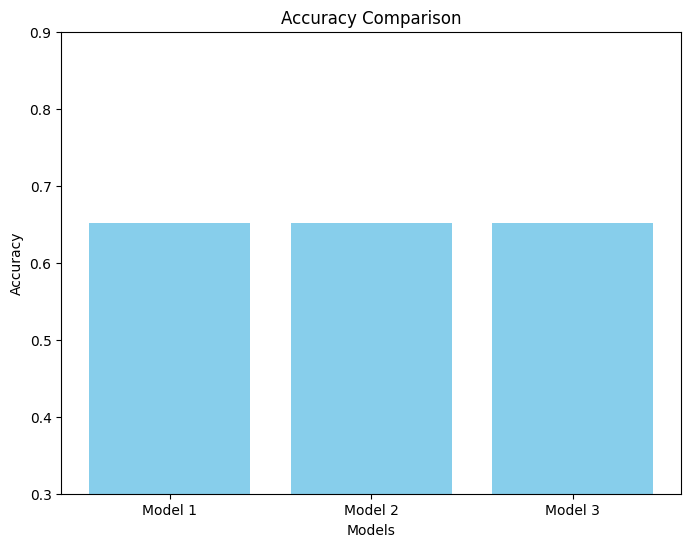

In [ ]:
#plotting the comparison between the models
multiclass_svm_model2 = MulticlassSVM(lmb=0.8, n_iters=1000)
multiclass_svm_model2.fit(X_train_numpy, Y_train_numpy)
multiclass_svm_model3 = MulticlassSVM(lmb=0.001, n_iters=500)
multiclass_svm_model3.fit(X_train_numpy, Y_train_numpy)

predictions2 = multiclass_svm_model.predict(X_test_numpy)
predictions3 = multiclass_svm_model.predict(X_test_numpy)

accuracy_1 = calculate_accuracy(predictions1, Y_test_numpy)

predictions_2 = multiclass_svm_model2.predict(X_test_numpy)
accuracy_2 = calculate_accuracy(predictions2, Y_test_numpy)

predictions_3 = multiclass_svm_model3.predict(X_test_numpy)
accuracy_3 = calculate_accuracy(predictions3, Y_test_numpy)

plt.figure(figsize=(8, 6))
models = ['Model 1', 'Model 2', 'Model 3']
accuracies = [accuracy_1, accuracy_2, accuracy_3]
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0.3, 0.90)
plt.show()


# Model Comparison


*   Effect of learning rate: Keeping the learning rate very low, has reduced the model's accuracy whereas a good learning rate like 0.01 gives it a better accuracy.
*   Effect on number of iterations: Reducing the number of iterations has also reduced the accuracy.
*   Keeping the margin at 1.0 gives better result than reducing it to 0.5(model 3).









##**Model Accuracies**

The order of accuracy for AdaBoost (70), Decision Tree (65), and SVM (69) can be justified based on their inherent characteristics and how they handle different types of data:

AdaBoost (74):
Strength in Ensembling: AdaBoost excels in combining weak learners to form a strong, robust model.
Correcting Errors: Its iterative approach focuses on correcting misclassifications, leading to improved accuracy.
Versatility: AdaBoost is versatile and less prone to overfitting, making it effective across various datasets.

Decision Tree (65) :
Prone to Overfitting: Decision trees, especially deep ones, are prone to overfitting, impacting accuracy on new data.
Sensitivity to Noise: They may capture noise and outliers, affecting generalization.
Interpretability: While interpretable, decision trees may struggle with complex relationships in the data.

SVM (69):
Margin Optimization: SVM aims to find the optimal hyperplane, providing a robust decision boundary.
Effective in High Dimensions: SVM performs well in high-dimensional spaces, suitable for diverse datasets.
Sensitivity to Noise: SVM is less sensitive to noisy data compared to decision trees but may be affected by outliers.
These justifications suggest that AdaBoost, with its ensemble approach, achieves the highest accuracy, while Decision Tree and SVM follow, each with its strengths and weaknesses affecting their performance on the specific dataset.

# **_5. References_**

1.   List item
2.   List item

